#### This notebook solves the equations of motion for the IR theory and determines its screening properties

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import dolfin as d
import numpy as np

from atplmesh import ArcTanPowerLawMesh
from atexpmesh import ArcTanExpMesh
from fem import Fem

from tophatsource import TopHatSource, StepSource

from IR import IRFields, IRSolver
from gravity import PoissonSolver

from utils import project, get_values

First define the problem and the mesh. Every parameter not defined here will be set to its default value. You can visualise your mesh using one of the notebooks provided: ATEMesh.ipynb, EMesh.ipynb, QMesh.ipynb

In [2]:
mesh = ArcTanPowerLawMesh( num_cells=2300, gamma=8, k=15., r_max=1e13 )
fem = Fem( mesh, func_degree=7 )

In [3]:
# source and UV fields
source = TopHatSource( fem, Ms=1e28, Rs=7e49, w=0.02 )
fields = IRFields( m=1e-56, Lambda=1e-46, epsilon=3e-3, n=3 )

In [4]:
irs = IRSolver( fem, source, fields, rel_res_tol=1e-100, abs_res_tol=1e-100,
               max_iter=30)
irs.solve()

Getting NL initial guess...
Non-linear solver, iteration 0	abs_du = 3.5e+27	rel_du = 3.1e+07	abs_res = 1.7e+42 (tol = 1.0e-100)	rel_res = 1.0e+00 (tol = 1.0e-100)
Non-linear solver, iteration 1	abs_du = 1.3e+17	rel_du = 1.1e-03	abs_res = 8.7e+21 (tol = 1.0e-100)	rel_res = 5.0e-21 (tol = 1.0e-100)
Non-linear solver, iteration 2	abs_du = 1.1e+15	rel_du = 9.5e-06	abs_res = 1.7e+20 (tol = 1.0e-100)	rel_res = 9.6e-23 (tol = 1.0e-100)
Non-linear solver, iteration 3	abs_du = 2.1e+13	rel_du = 1.8e-07	abs_res = 4.0e+18 (tol = 1.0e-100)	rel_res = 2.3e-24 (tol = 1.0e-100)
Non-linear solver, iteration 4	abs_du = 4.7e+11	rel_du = 4.1e-09	abs_res = 5.4e+16 (tol = 1.0e-100)	rel_res = 3.1e-26 (tol = 1.0e-100)
Non-linear solver, iteration 5	abs_du = 9.2e+09	rel_du = 8.0e-11	abs_res = 3.1e+14 (tol = 1.0e-100)	rel_res = 1.8e-28 (tol = 1.0e-100)
Non-linear solver, iteration 6	abs_du = 5.9e+09	rel_du = 5.1e-11	abs_res = 2.1e+10 (tol = 1.0e-100)	rel_res = 1.2e-32 (tol = 1.0e-100)
Non-linear solver, iteratio

This is where your mesh vertices are distributed. You can explore more properties of your mesh using one of the notebooks provided: ATEMesh.ipynb, EMesh.ipynb or QMesh.ipynb

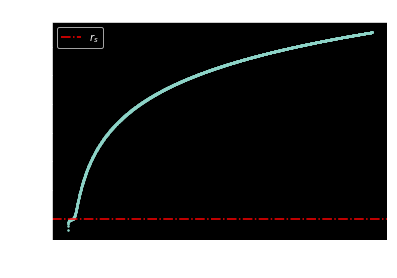

In [5]:
plt.title('Mesh vertices')
plt.plot( mesh.mesh.coordinates(), '.', markersize='3' )
plt.ylabel(r'$r$')
plt.xlabel('index')
plt.axhline(y=mesh.rs, color='red', linestyle='-.', label=r'$r_s$')
plt.yscale('log')
plt.legend()

This is what your source looks like (around the source-vacuum transition)

(0.0, 3)

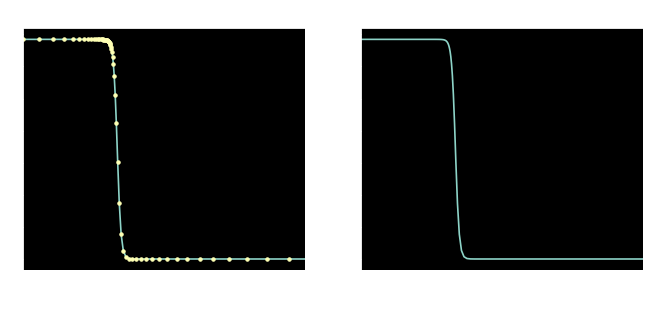

In [6]:
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')

# cast rho as a Function (not necessary for plotting, but helpful to compute
# On operators later)

plt.subplot(121)
plt.title(r'$\rho$ ($M_p^4$)')
rho = d.interpolate( source.rho, fem.S )
r_values, rho_values = get_values( rho, output_mesh=True )
Rho_values = irs.Mn**3 * rho_values # get physical units
plt.plot( r_values, Rho_values )
plt.plot( r_values, Rho_values, '.' )
plt.xlabel(r'$r/r_s$')
plt.xlim([0., 3])

# using units Mp^4
plt.subplot(122)
plt.title(r'$\rho$ ($M_p^4$)')
plt.plot( r_values, Rho_values, '-' )
plt.xlabel(r'$r/r_s$')
plt.xlim([ 0., 3 ])

#####    
Check the solver has finished: you should see a plateau in these two plots

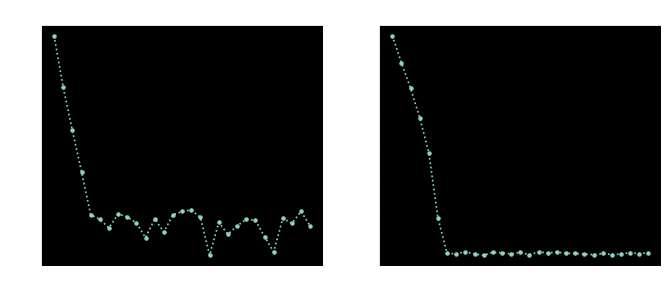

In [7]:
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')

abs_du = irs.abs_du[1:]
abs_res = irs.abs_res[1:]

# change in the solution (du) at every iteration
plt.subplot(121)
plt.title('Absolute du, norm=%s' % irs.norm_change )
plt.plot( abs_du[abs_du>0.], ':.' )
#plt.xlim([0,40])
plt.yscale('log')

# weak residual at every iteration
plt.subplot(122)
plt.title('Absolute res, norm=%s' % irs.norm_res )
plt.plot( abs_res[abs_res>0.], ':.' )
#plt.xlim([0,40])
plt.yscale('log')

#####    
Print the _strong_ residual (i.e. difference bw two sides of equations) across the whole box, as well as the maximum residual at vertices
WARNING: if your interpolating polynomials are degree less than 3 these numbers will not be reliable

In [8]:
print 'absolute residual (L2 norm over the whole box): %.1e' \
                    % irs.strong_residual( irs.u, norm='L2' )
print 'absolute max residual at vertices: %.1e' \
                    % irs.strong_residual( irs.u, norm='linf' )

print '\nMax abs value at vertices in EoM:'
print 'LHS: %.5e' % irs.output_term(eqn=3, term='LHS', norm='linf')
print 'RHS: %.5e' % irs.output_term(eqn=3, term='RHS', norm='linf')

absolute residual (L2 norm over the whole box): 2.7e+13
absolute max residual at vertices: 2.5e+10

Max abs value at vertices in EoM:
LHS: 8.68077e+13
RHS: 8.68077e+13


#####      
Extract value of Pi/w/Y at vertices, for plotting. Pi and Y are in physical units, w in rescaled units because it's too small

In [9]:
Pi, w, Y = irs.Pi, irs.w, irs.Y
r_values, Pi_values = get_values( Pi, output_mesh=True )
w_values = get_values(w)
Y_values = get_values(Y)

get strong residual at all mesh vertices, for plotting

In [10]:
F = irs.strong_residual( irs.u, norm='none' )
F1, F2, F3 = F.split(deepcopy=True) # residuals for Eqns. 1, 2 and 3
F1_values = get_values(F1)
F2_values = get_values(F2)
F3_values = get_values(F3)
# useful for log scale
F1_mask = ( F1_values > 0. )
F2_mask = ( F2_values > 0. )
F3_mask = ( F3_values > 0. )

######    
compare the different terms in the equations. Adjust y limits in this plot as well as all others below (unfortunately, it's difficult to predict those limits)

********************************************************************************************************************
********************************************************************************************************************
********************************************************************************************************************
********************************************************************************************************************
********************************************************************************************************************
********************************************************************************************************************
********************************************************************************************************************
********************************************************************************************************************


(1e-180, 1e-110)

/usr/local/lib/python2.7/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


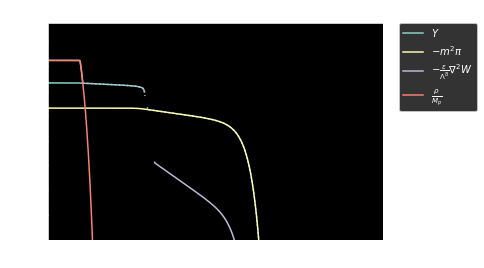

In [11]:
plt.title('Physical units')

# equation 3
eqn = 3
for j in range(1,5):
    term, label = irs.output_term( eqn=eqn, term=j, units='physical', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([1e-180, 1e-110])
#plt.xlim(1e-3, 1e3)

(1e-40, 1e+20)

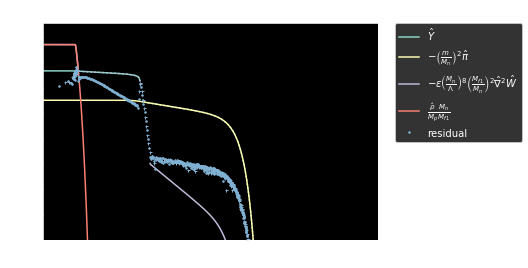

In [12]:
plt.title('Code units')

# equation 3
eqn = 3
for j in range(1,5):
    term, label = irs.output_term( eqn=eqn, term=j, output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residuals 
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F3_mask], F3_values[F3_mask], '.',
         color=colour, markersize='3', label='residual' )
plt.plot( r_values[~F3_mask], abs(F3_values[~F3_mask]), '+',
         color=colour, markersize='3' )

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([1e-40, 1e20])
#plt.xlim(1e-3, 1e3)

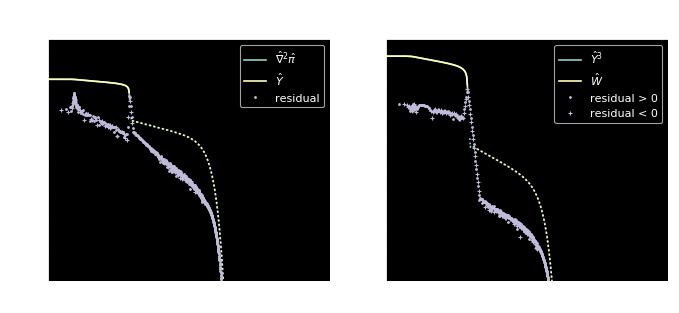

In [13]:
fig=plt.figure(figsize=(10, 4), dpi=80 )

plt.suptitle(r'Consistency of $\hat{Y}=\hat{\nabla}^2\hat{\pi}$ and $\hat{W}=\hat{Y}^3$')

# Y = Del pi
plt.subplot(121)
eqn = 1
for j in range(1,3):
    term, label = irs.output_term( eqn=eqn, term=j, norm='none', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F1_mask], F1_values[F1_mask], '.',
         color=colour, markersize='3', label='residual' )
plt.plot( r_values[~F1_mask], abs(F1_values[~F1_mask]), '+',
         color=colour, markersize='3' )

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-35,1e15])
#plt.xlim(1e1,2e1)
plt.legend()


# W = Y^3
plt.subplot(122)
eqn = 2
for j in range(1,3):
    term, label = irs.output_term( eqn=eqn, term=j, norm='none', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F2_mask], F2_values[F2_mask], '.',
         color=colour, markersize='3',
         label='residual > 0' )
plt.plot( r_values[~F2_mask], abs(F2_values[~F2_mask]), '+',
         color=colour, markersize='3', label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-45,1e25])
#plt.xlim(1e1,2e1)
plt.legend()

######   
Now we have checked some diagnostic plots we can look at the solution and compare against the theory

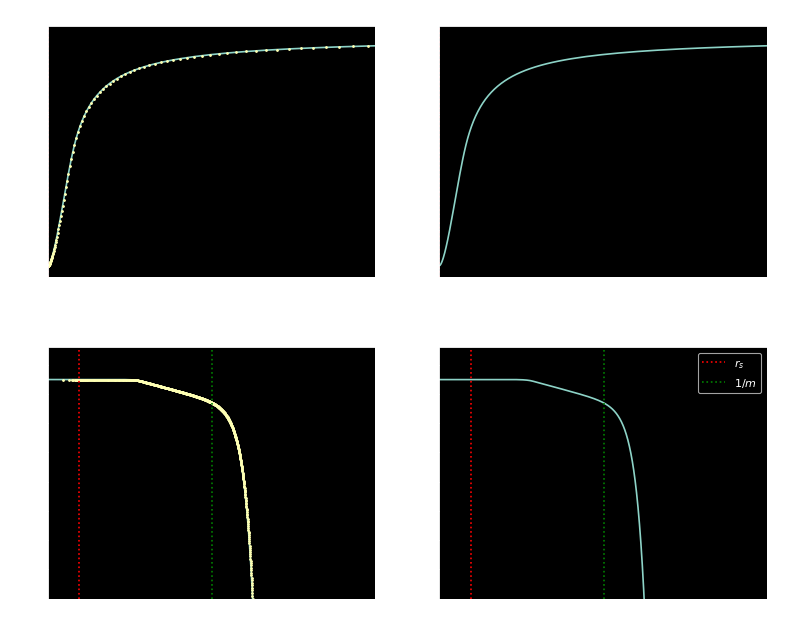

In [14]:
# for ease of visualisation, only plot function up to...
Pi_r_stop = mesh.rs * 10000.

fig=plt.figure(figsize=(10, 8), dpi=80 )

# field around the source
plt.subplot(221)
plt.title(r'$\pi$ (Mp), around the source')
plt.plot( r_values, Pi_values )
plt.plot( r_values, Pi_values, '.', markersize=3 )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0., Pi_r_stop])

plt.subplot(222)
plt.title(r'$\pi$ (Mp), around the source')
plt.plot( r_values, Pi_values, )
plt.xlabel(r'$\hat{r}=r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.xlim([ 0., Pi_r_stop ])

# field across the whole box
plt.subplot(223)
plt.title(r'$\pi$ (Mp) - whole box')
plt.plot( r_values, abs(Pi_values) )
plt.plot( r_values, abs(Pi_values), '.', markersize=3 )
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$')
plt.axvline(x=irs.Mn / fields.m, linestyle=':', color='green', label=r'$1/m$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-63, 1e-20])
#plt.xlim(1e-7, 1e9)

plt.subplot(224)
plt.title(r'$\pi$ (Mp) - whole box')
plt.plot( r_values, abs(Pi_values) )
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=mesh.rs, color='red', linestyle=':', label=r'$r_s$')
plt.axvline(x=irs.Mn / fields.m, linestyle=':', color='green', label=r'$1/m$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-63, 1e-20])
#plt.xlim(1e-7, 1e9)

plt.legend()
plt.tight_layout()

w and comparison against the theory (top hat source only!)
To avoid hitting the minimum representable number, use the rescaled units employed inside the code

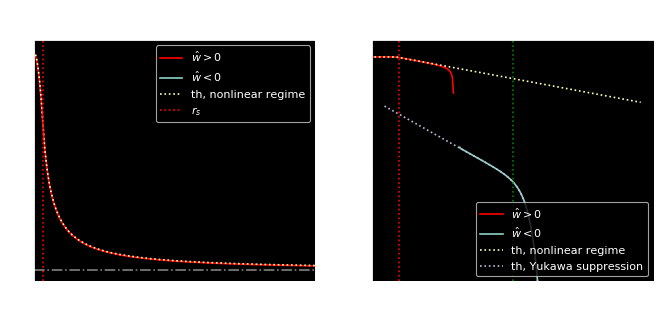

In [15]:
# theoretical expectation for the nonlinear regime
rho0 = 3. * irs.source.Ms / ( 4. * np.pi * irs.fem.mesh.rs**3 )

wNL_th_code = 'x[0] < rs + DOLFIN_EPS ? ' + \
'pow(Lambda/Mn,3*n-1) * pow( Mn/Mf1,n ) / epsilon / Mp * Ms / (8.*pi*rs) * (3. - pow(x[0]/rs,2)) : ' + \
'pow(Lambda/Mn,3*n-1) * pow( Mn/Mf1,n ) / epsilon / Mp * Ms / (4.*pi) / x[0]'

wNL_th = d.Expression( wNL_th_code, degree=irs.fem.func_degree, 
                   Ms=irs.source.Ms, rs=irs.fem.mesh.rs, Mp=irs.fields.Mp, 
                   Lambda=irs.fields.Lambda, n=irs.fields.n, epsilon=irs.fields.epsilon,
                   Mn=irs.Mn, Mf1=irs.Mf1 )

wNL_th = d.interpolate( wNL_th, irs.fem.S )
wNL_th_values = get_values( wNL_th )

# theoretical expectation for the Yukawa suppression
r_piv = 1e4
c_piv = irs.pi(r_piv) * r_piv / np.exp( -irs.fields.m / irs.Mn * r_piv ) 

wYS_th_code = 'pow(c_piv * pow(m/Mn,2) * exp(-m/Mn*x[0])/x[0],n)'

wYS_th = d.Expression( wYS_th_code, degree=irs.fem.func_degree,
                     m=irs.fields.m, n=irs.fields.n, Mn=irs.Mn, c_piv=c_piv )

wYS_th = d.interpolate( wYS_th, irs.fem.S )
wYS_th_values = get_values( wYS_th )


# for ease of visualisation, only plot function up to...
w_r_stop = mesh.rs * 30.

w_pos = np.ma.masked_where( w_values < 0., w_values )
w_neg = np.ma.masked_where( w_values > 0., w_values )

fig=plt.figure(figsize=(10, 4), dpi=80 )

# rescaled field around the source
plt.suptitle( r'$\hat{w}=W/10^{%.f}$' % \
          ( 3. * ( 2.*np.log10(irs.Mn) + np.log10(irs.Mf1) ) ) )

plt.subplot(121)
plt.title(r'$\hat{w}$ - around the source')
plt.plot( r_values, w_pos, 'r-', label=r'$\hat{w}>0$' )
plt.plot( r_values, w_neg, '-', label=r'$\hat{w}<0$' )
plt.plot( r_values, wNL_th_values, ':', label='th, nonlinear regime' )
#plt.plot( r_values, wYS_th_values, ':', label='th, Yukawa suppression')
plt.xlabel(r'$\hat{r}$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$' )
plt.axhline(y=0, color='grey', linestyle='-.' )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0., w_r_stop])
plt.legend()


# rescaled field across the whole box
plt.subplot(122)
plt.title(r'$|\hat{w}|$ - whole box')
plt.plot( r_values, w_pos, 'r-', label=r'$\hat{w}>0$' )
plt.plot( r_values, abs(w_neg), '-', label=r'$\hat{w}<0$' )
plt.plot( r_values, abs(wNL_th_values), ':', label='th, nonlinear regime' )
plt.plot( r_values, abs(wYS_th_values), ':', label='th, Yukawa suppression')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.axvline(x=irs.Mn / irs.fields.m, linestyle=':', color='green')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-45, 1e25])
plt.legend()


Y and comparison againt the theory

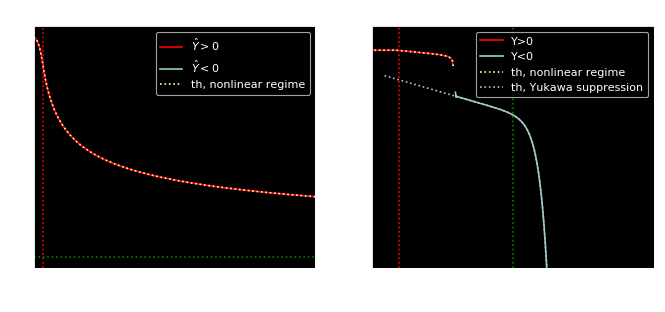

In [16]:
# theoretical expectation for the nonlinear regime
YNL_th_code = 'pow(Mn,2) * Mf1 * pow(w,1./n)'
YNL_th = d.Expression( YNL_th_code, degree=irs.fem.func_degree,
                     w=irs.w, n=irs.fields.n, Mn=irs.Mn, Mf1=irs.Mf1)
YNL_th = d.interpolate( YNL_th, irs.fem.S )
YNL_th_values = get_values( YNL_th )

# theoretical expectation for the Yukawa suppression
YYS_th_code = 'pow(Mn,2) * Mf1 * c_piv * pow(m/Mn,2) * exp(-m/Mn*x[0])/x[0]'
YYS_th = d.Expression( YYS_th_code, degree=irs.fem.func_degree,
                     c_piv=c_piv, m=irs.fields.m, Mn=irs.Mn, Mf1=irs.Mf1 )
YYS_th = d.interpolate( YYS_th, irs.fem.S )
YYS_th_values = get_values( YYS_th )

# for ease of visualisation, only plot function up to...
Y_r_stop = irs.fem.mesh.rs * 30.

Y_pos = np.ma.masked_where( Y_values < 0., Y_values )
Y_neg = np.ma.masked_where( Y_values > 0., Y_values )

fig=plt.figure(figsize=(10, 4), dpi=80 )

# rescaled field around the source
plt.subplot(121)
plt.title( r'$Y$ ($M_p$), around the source' )
plt.plot( r_values, Y_pos, 'r-', label=r'$\hat{Y}>0$' )
plt.plot( r_values, Y_neg, '-', label=r'$\hat{Y}<0$' )
plt.plot( r_values, YNL_th_values, ':', label='th, nonlinear regime' )
#plt.plot( r_values, YYS_th_values, ':', label='th, Yukawa suppression' )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.axhline(y=0., color='green', linestyle=':')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0., Y_r_stop])
plt.legend()


# rescaled field across the whole box
plt.subplot(122)
plt.title(r'$|Y|$ ($M_p$) - whole box')
#Y_nz = ( abs(Y_values)> 0. ) # phi non zero
plt.plot( r_values, Y_pos, 'r-', label=r'Y>0' )
plt.plot( r_values, abs(Y_neg), '-', label=r'Y<0' )
plt.plot( r_values, abs(YNL_th_values), ':', label='th, nonlinear regime' )
plt.plot( r_values, abs(YYS_th_values), ':', label='th, Yukawa suppression' )
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.axvline(x=irs.Mn / irs.fields.m, linestyle=':', color='green')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-170, 1e-125])
plt.legend()

gradients

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


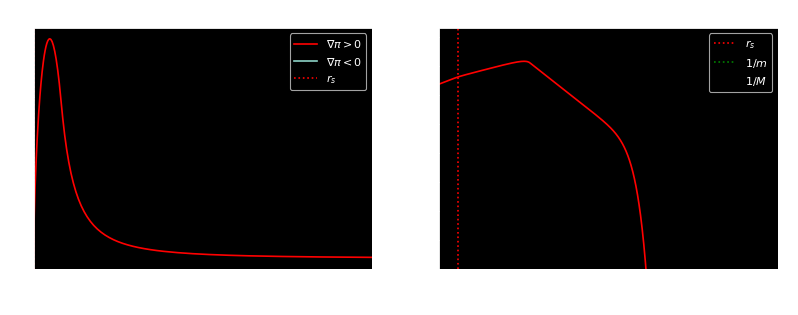

In [17]:
grad_Pi_values = get_values( irs.grad_Pi )

grad_Pi_pos = np.ma.masked_where( grad_Pi_values < 0., grad_Pi_values )
grad_Pi_neg = np.ma.masked_where( grad_Pi_values > 0., grad_Pi_values )

fig=plt.figure(figsize=(12, 4), dpi=80 )

plt.subplot(121)
plt.title(r'$\nabla\pi$ ($M_p^2$), around the source')
plt.plot( r_values, grad_Pi_pos, 'r-', label=r'$\nabla\pi>0$' )
plt.plot( r_values, grad_Pi_neg, '-', label=r'$\nabla\pi<0$' )
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$')
plt.xlim( 0., Pi_r_stop )
#plt.ylim( 0., 1e-51)
plt.xlabel(r'$\hat{r}$')
plt.legend()

plt.subplot(122)
plt.title(r'$\nabla\pi$ ($M_p^2$) whole box')
plt.plot( r_values, grad_Pi_pos, 'r-' )
plt.plot( r_values, abs(grad_Pi_neg), '-' )
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$')
plt.axvline(x=1./irs.fields.m, color='green', linestyle=':', label=r'$1/m$')
plt.axvline(x=1./irs.fields.Lambda, color='black', linestyle=':', label=r'$1/M$')

plt.xscale('log')
plt.yscale('log')

plt.xlim(irs.fem.mesh.r_min, irs.fem.mesh.r_max)
plt.ylim(1e-100, 1e-75)
plt.legend()

#####    
Now compute the Newton force by solving the Poisson equation

(1e-180, 1e-110)

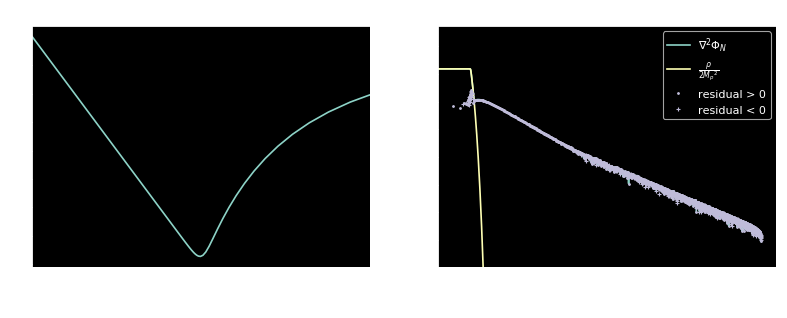

In [18]:
gs = PoissonSolver( fem, source )
gs.solve()
Newton_values = get_values( gs.Newton_force )
gF_values = get_values( gs.strong_residual( gs.PhiN, norm='none', units='physical' ) )
gF_mask = ( gF_values > 0. )


fig=plt.figure(figsize=(12, 4), dpi=80 )

plt.subplot(121)
plt.title(r'$F_N$ in units 1/Mp')
plt.plot( r_values, Newton_values, '-' )
plt.xlim( 0., irs.fem.mesh.rs * 2. )
plt.xlabel(r'$r/r_s$')

plt.subplot(122)
plt.title(r'Gravitational field - residuals')
for i, side in enumerate(['LHS','RHS']):
    term, label = gs.output_term( term=side, units='physical', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )

# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[gF_mask], gF_values[gF_mask], '.',
         color=colour, markersize='3', label='residual > 0' )
plt.plot( r_values[~gF_mask], abs(gF_values[~gF_mask]), '+',
         color=colour, markersize='3', label='residual < 0' )

plt.xlabel(r'$r/r_s$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(1e-180,1e-110)

######  
compare strength of scalar vs Newton force: a value of two in the scalar/Newton force ratio indicates they are the same strength (as a consequence of our normalisation) a value of 2 or higher indicates there is no screening

Text(0.5,0,u'$r/r_s$')

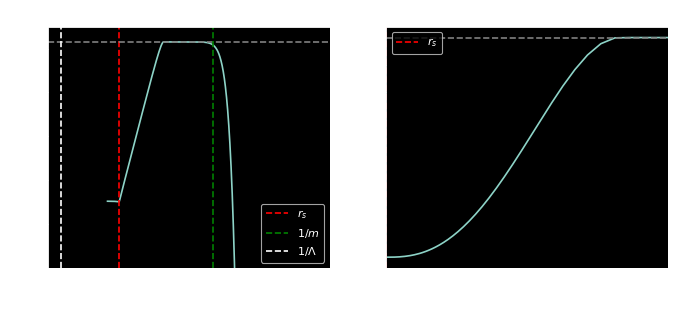

In [19]:
fig=plt.figure(figsize=(10, 4), dpi=80 )

plt.subplot(121)
plt.title(r'$F_{\pi}/F_N$')

Pi_force_values = get_values( irs.force )

comparison = Pi_force_values / Newton_values
plt.plot( r_values[1:], comparison[1:], '-' )
#plt.plot( r_values, comparison, '.')
plt.xlabel(r'$r/r_s$')

plt.axvline( x = irs.fem.mesh.rs, color='r', linestyle='--', label=r'$r_s$' )
plt.axhline( y = 2., color='grey', linestyle='--' )
plt.axvline( x = irs.Mn/irs.fields.m, color='g', linestyle='--', label=r'$1/m$')
plt.axvline( x = irs.Mn/irs.fields.Lambda, linestyle='--', label=r'$1/\Lambda$')

plt.xlabel('r')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e1])
#plt.xlim(1e45,1e50)
plt.legend()


plt.subplot(122)
plt.title(r'$F_{\pi}/F_N$ - around the source')

plt.plot( r_values[1:], comparison[1:] )

plt.axvline( x = irs.fem.mesh.rs, color='r', linestyle='--', label=r'$r_s$' )
plt.axhline( y = 2., color='grey', linestyle='--' )
plt.legend(loc=2)
plt.xlim( 0., irs.fem.mesh.rs * 1000. )
#plt.ylim(2-1e-1,2+1e-1)
plt.xlabel(r'$r/r_s$')

#####   
Compare some On operators in log scale

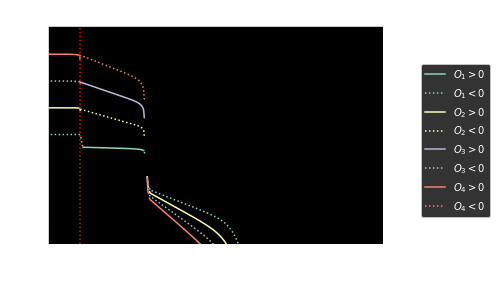

In [20]:
# Comparison of a few operators in log scale

plt.title(r'$On$ in $M_p^3$, across box')
K_array = np.ones(10)
for n in range(1,5):
    phys_On = irs.On( n, rescale=K_array[n] )
    phys_On_values = get_values( phys_On )
    phys_On_pos = np.ma.masked_where( phys_On_values < 0., phys_On_values )
    phys_On_neg = np.ma.masked_where( phys_On_values > 0., phys_On_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, phys_On_pos, '-', label=r'$O_{%d}>0$' % n, color=colour )
    plt.plot( r_values, abs(phys_On_neg), ':', label=r'$O_{%d}<0$' % n, color=colour )
    plt.xlabel(r'$\hat{r}$')
       
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-185, 1e-60)
plt.legend(bbox_to_anchor=(1.1,.1), loc='lower left')

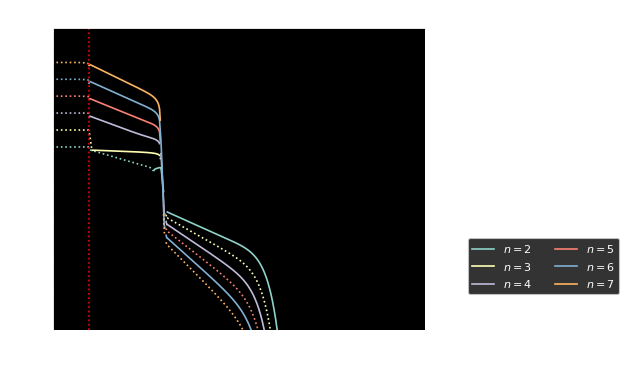

In [21]:
# Even and odd operators together

fig=plt.figure(figsize=(6, 5), dpi=80 )

plt.title(r'$Q_n$ in units $M_p^3$')
K_array = np.ones(10)
for n in range(2,8):
    Qn_phys = irs.Qn( n, rescale=K_array[n] )
    Qn_values = get_values( Qn_phys )
    Qn_pos = np.ma.masked_where( Qn_values < 0., Qn_values )
    Qn_neg = np.ma.masked_where( Qn_values > 0., Qn_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, Qn_pos, '-', label=r'$n=%d$' % n, color=colour )
    plt.plot( r_values, abs(Qn_neg), ':', color=colour )
    plt.xlabel(r'$\hat{r}$')

plt.axvline(x=irs.fem.mesh.rs, color='red', linestyle=':')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-1, 1e6)
plt.ylim(1e-200, 1e-90)
plt.legend(bbox_to_anchor=(1.1,.1), loc='lower left', ncol=2)